# Multiple Linear Regression
## Bike Sharing Demand


### Problems:
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

### Business Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

## <font color="blue">Envionment Setup</font>

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score


import math 
import calendar
#import plotly.graph_objects as go

from scipy import stats

## <font color="blue">EDA -- Data sourcing part</font>

In [198]:
df=pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


***Information pertaining to Meta Data has been taken from following link***

https://cdn.upgrad.com/uploads/production/0fdfa494-a9bf-4b32-873f-900e3b262948/Readme.txt

## <font color="blue">Functions (User Defined) Used<font>

In [199]:
# This function displays the information about master dataset required repetitively in EDA 
def qck():
  print(f"Dimenssion of Master Data: {df.shape}")
  #summery=pd.DataFrame(df.dtypes, columns=['dtypes'])
  summery=pd.DataFrame({"dtypes":df.dtypes})
  summery['Name'] = summery.index
  summery['missing']=df.isnull().sum()
  summery['missing%']=100*df.isnull().sum()/len(df)
  summery['unq_cnt']=df.nunique()
  return summery


# This function draw the boxplots in customised way. 
def box_plot(lst, yy):
  row=int(math.ceil(len(lst)/2))
  ax=0
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(16,18))
  for xx in lst:
    ndf2=df.groupby([xx])["cnt"].describe().reset_index()
    ax=ax+1
    plt.subplot(row,2, ax)
    gg=sns.boxplot(data=df, x=xx, y=yy)
    for tick in range(len(gg.get_xticklabels())):
         gg.text(tick,  ndf2.loc[tick,"50%"], ndf2.loc[tick,"50%"], horizontalalignment='center',  color='w', weight='semibold')   
    plt.tight_layout()
  plt.show()  

 
# This function is to normalize the occurance of categorical data and calculate sum of the 'cnt' feature category wise and find percentage.    
ycnt=df.cnt.sum()
def perc_variance_per_unit_occurance(x):
    tt= x/ycnt
    ttt= tt.sum()
    tttt=ttt/tt.count()
    return tttt

def perc_variance(y):
    tt= y/ycnt
    return tt.sum()

# This function draws the barplot  of each category towards the output feature "cnt" and generates high information content table  
info_cnt_df=pd.DataFrame()
def uv(lst, normallise, x, y):
  max_cnt=[]
  min_cnt=[]
  dif_cnt=[]  
  des_cnt=[]
  count=0 
  row=math.ceil(len(lst)/2)
  plt.figure(figsize=(x,y))
  for xx in lst:
    count=count+1
    if(normallise==0):
     ndf=df.groupby([xx])["cnt"].agg(perc_variance_per_unit_occurance).reset_index()
    else:
     ndf=df.groupby([xx])["cnt"].agg(perc_variance).reset_index()
    #ndf=df.groupby(["mnth"])["cnt"].agg(['sum','count',perc_variance_per_unit_occurance]).reset_index()
    max_cnt.append(ndf.cnt.max())
    min_cnt.append(ndf.cnt.min())
    dif_cnt.append(ndf.cnt.max()-ndf.cnt.min()) 
    des_cnt.append(xx)     
    plt.subplot(row,2, count)
    gg=sns.barplot(data=ndf, x=xx, y="cnt")
    gg.set_xticklabels(gg.get_xticklabels(),rotation=45, fontsize=12)
    gg.set_title(xx + "- cnt", fontsize=14)
    #plt.tight_layout()
    for p in gg.patches:
            gg.annotate(format(100*p.get_height(), '.2f') +" %", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +11), 
                       textcoords = 'offset points')
    plt.tight_layout()
  plt.show()
  if(normallise==1):
      info_cnt_df['Predictor']=des_cnt
      info_cnt_df['Max_val']=max_cnt
      info_cnt_df['Min_val']=min_cnt
      info_cnt_df['Variance']=dif_cnt

#This functon calculates VIF
def vif_runner(xx):
    vif = pd.DataFrame()
    X = xx
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

#This funtions helps to fit regression line of y_train and X_train if new feature is to be added to exixting X_train
mdl_list=["temp"]    
def append_feature(xx):
    mdl_list.append(xx)
    y_train = df_train['cnt']
    X_train = df_train[mdl_list]
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(y_train, X_train_sm).fit()
    print(lr.summary())
    print(vif_runner(X_train))
    print("Available Features: " , df_train.columns)
    print("Used Features: " , X_train.columns.tolist)
    
    
#This funtions helps to fit regression line of y_train and X_train if new feature is to be removed from exixting X_train    
def remove_feature(xx):
    mdl_list.remove(xx)
    y_train = df_train['cnt']
    X_train = df_train[mdl_list]
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(y_train, X_train_sm).fit()
    print(lr.summary())
    print(vif_runner(X_train))
    print("Available Features: " , df_train.columns)
    print("Used Features: " , X_train.columns.tolist)


In [200]:
qck()

Dimenssion of Master Data: (730, 16)


,dtypes,Name,missing,missing%,unq_cnt
instant,int64,instant,0,0.0,730
dteday,object,dteday,0,0.0,730
season,int64,season,0,0.0,4
yr,int64,yr,0,0.0,2
mnth,int64,mnth,0,0.0,12
holiday,int64,holiday,0,0.0,2
weekday,int64,weekday,0,0.0,7
workingday,int64,workingday,0,0.0,2
weathersit,int64,weathersit,0,0.0,3
temp,float64,temp,0,0.0,498


#### Remark: The Dataset does not have any missing value

In [201]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


#### Remark: In all numerical variables, it is found that mean and median are very close. So, it can be concluded that there is no outlier.

## <font color="blue">EDA</font>

In [202]:
#correlation matrix
df[['atemp','temp','windspeed','hum',"casual","registered","cnt"]].corr()

,atemp,temp,windspeed,hum,casual,registered,cnt
atemp,1.000000,0.991696,-0.183876,0.141512,0.543362,0.543678,0.630685
temp,0.991696,1.000000,-0.158186,0.128565,0.542731,0.539436,0.627044
windspeed,-0.183876,-0.158186,1.000000,-0.248506,-0.167995,-0.217914,-0.235132
hum,0.141512,0.128565,-0.248506,1.000000,-0.075211,-0.089212,-0.098543
casual,0.543362,0.542731,-0.167995,-0.075211,1.000000,0.394137,0.672123
registered,0.543678,0.539436,-0.217914,-0.089212,0.394137,1.000000,0.945411
cnt,0.630685,0.627044,-0.235132,-0.098543,0.672123,0.945411,1.000000


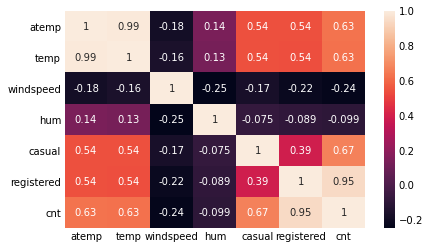

In [203]:
sns.heatmap(df[['atemp','temp','windspeed','hum',"casual","registered","cnt"]].corr(), annot=True)

### Pairplot To find highest correlation

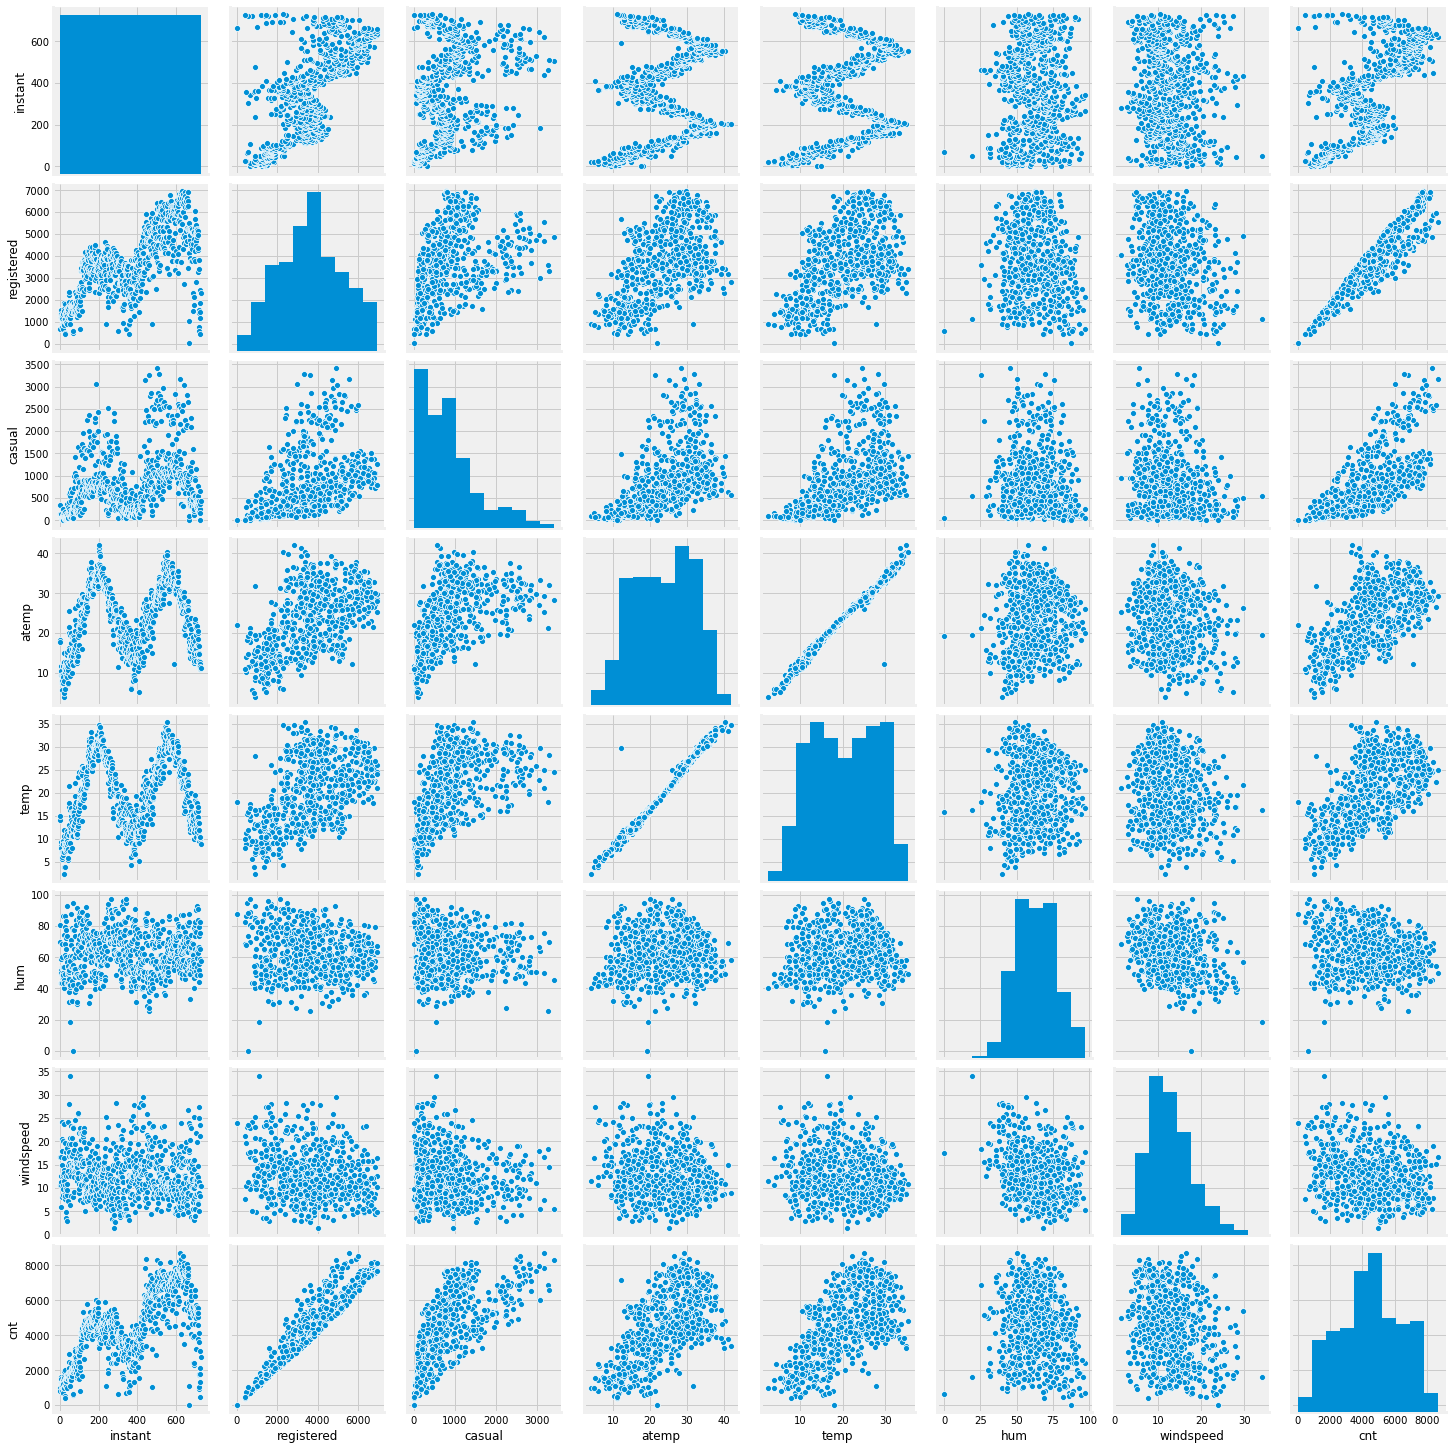

In [204]:
sns.pairplot(df[["instant","registered","casual", 'atemp','temp', 'hum', 'windspeed', 'cnt']])
plt.show()

### Dropping some useless and redundant columns
- instant -> This column hold serial number which is not required in analysis
- dteday -> This column is useless as there are separate columns mnth, yr, weekday, holiday, workingday.
- atemp -> From correlation matrix it is found that atemp and temp are much interelated, so we shall use only one and atemp can be dropped.
- registered & casual -> these two variables yield the cnt. So these two can be dropped.

In [205]:
#df.drop(["instant","dteday","atemp","registered","casual"], axis=1, inplace=True)
df.drop(["instant","dteday","registered","casual", 'atemp'], axis=1, inplace=True)

In [206]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [207]:
num_var_lst=['temp', 'hum', 'windspeed', 'cnt']
cat_var_lst= ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

## <font color='blue'>DATA Visualization</font>

### Visualization -1 (Target Variable)

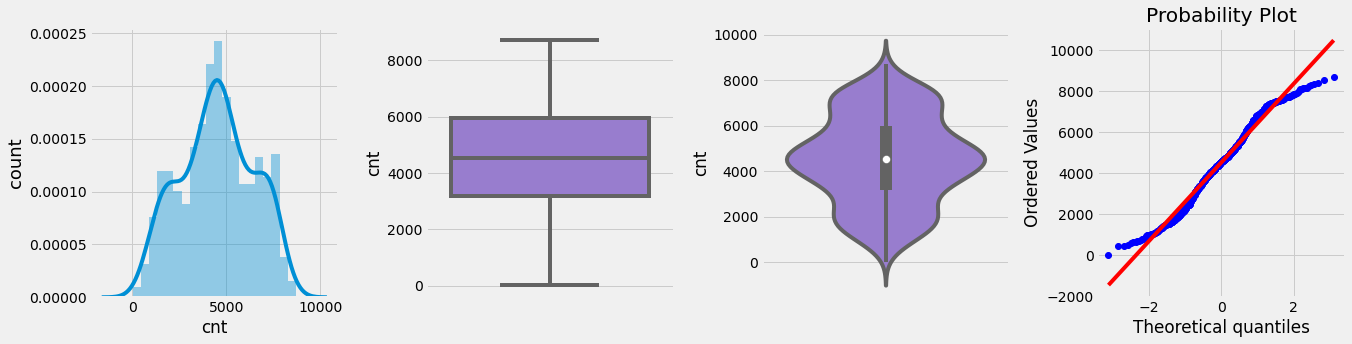

In [208]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(19, 5))
ax1=plt.subplot(1,4,1)
sns.distplot(df.cnt, bins = 20,)
plt.ylabel('count', fontsize = 18)
ax2=plt.subplot(1,4,2)
sns.boxplot(y = 'cnt', data = df, color = 'mediumpurple')
ax3=plt.subplot(1,4,3)
sns.violinplot(y = 'cnt', data = df, color = 'mediumpurple')
ax4=plt.subplot(1,4,4)
stats.probplot(df.cnt, plot=plt)
plt.tight_layout()
plt.show()

### Visualization -2 (Pair Grid)

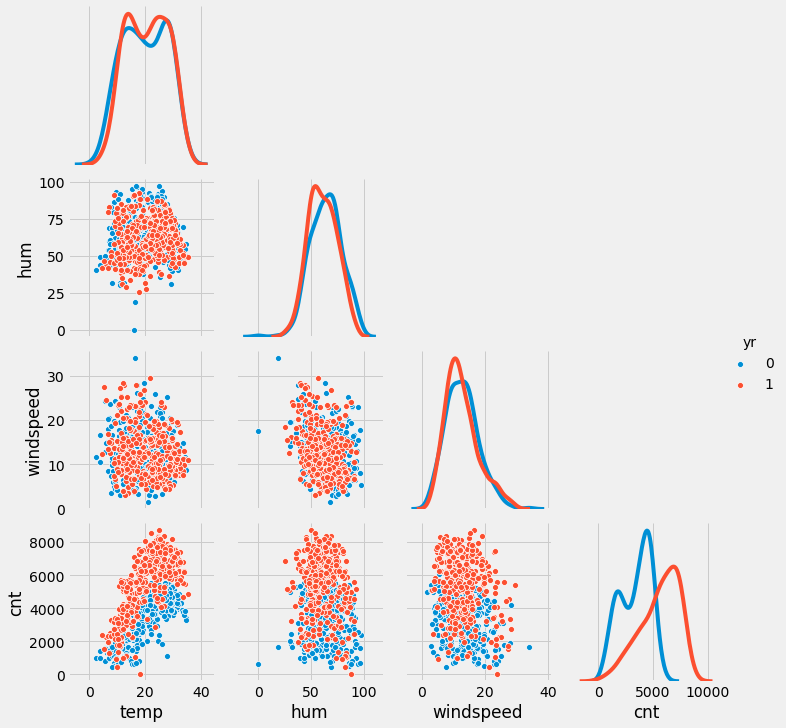

In [209]:
g = sns.PairGrid(data=df, vars=['temp', 'hum', 'windspeed', 'cnt'], diag_sharey=False, corner=True, hue="yr")
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend()
plt.show()

### Visualization -3 (Box Plot)

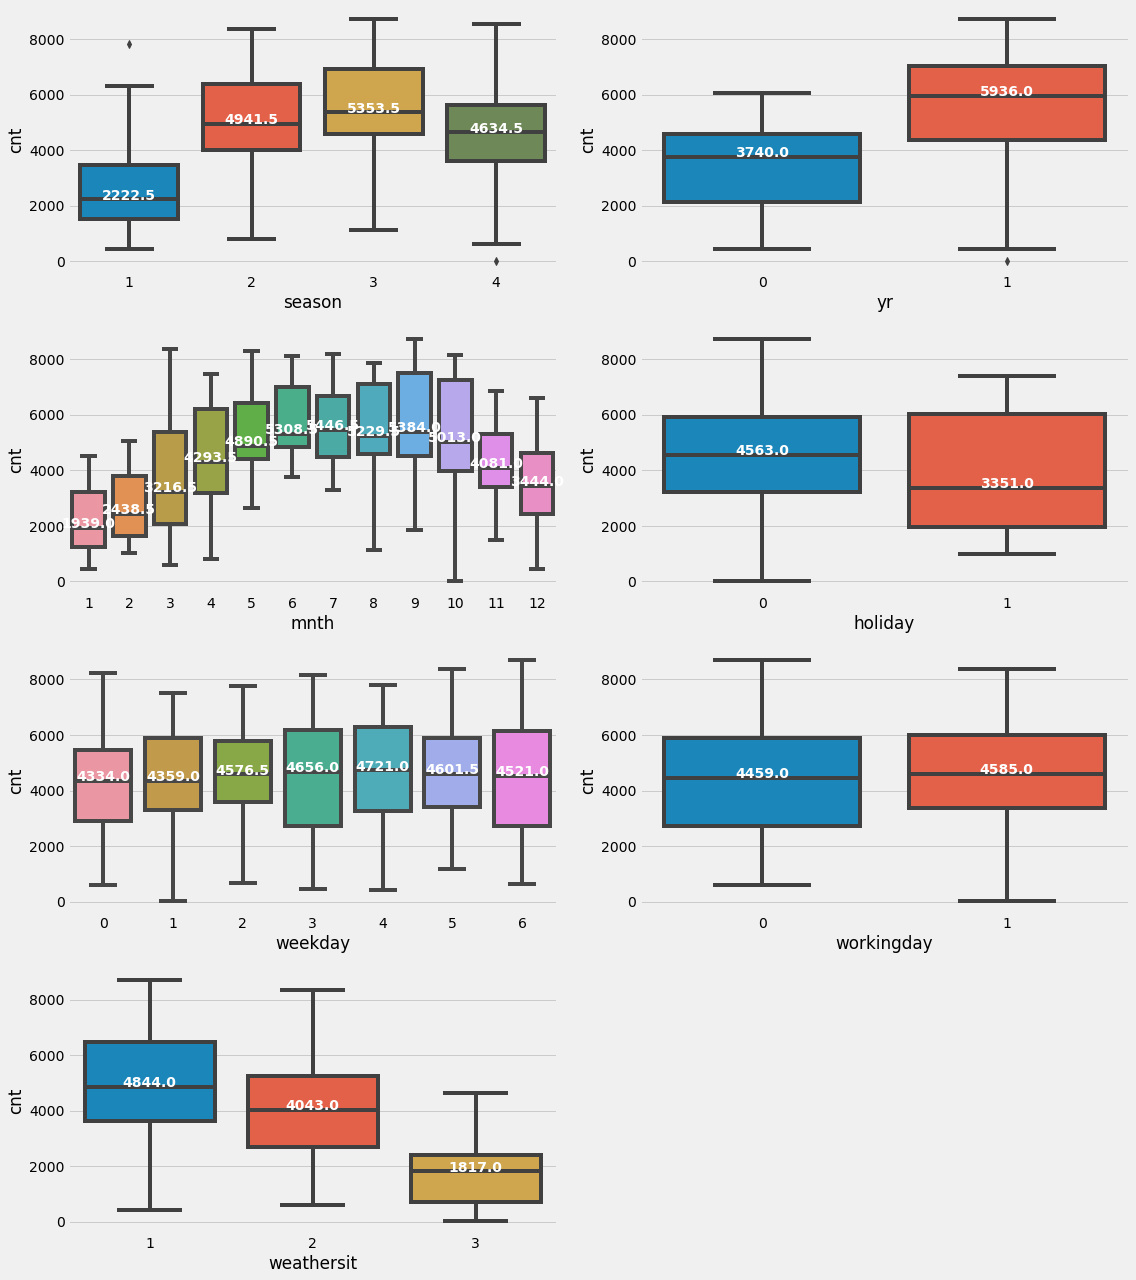

In [210]:
box_plot(cat_var_lst, df.cnt)

### Visualization -4 (Sum of 'cnt' Category & Sub Category wise in percentage to find High Information Content)

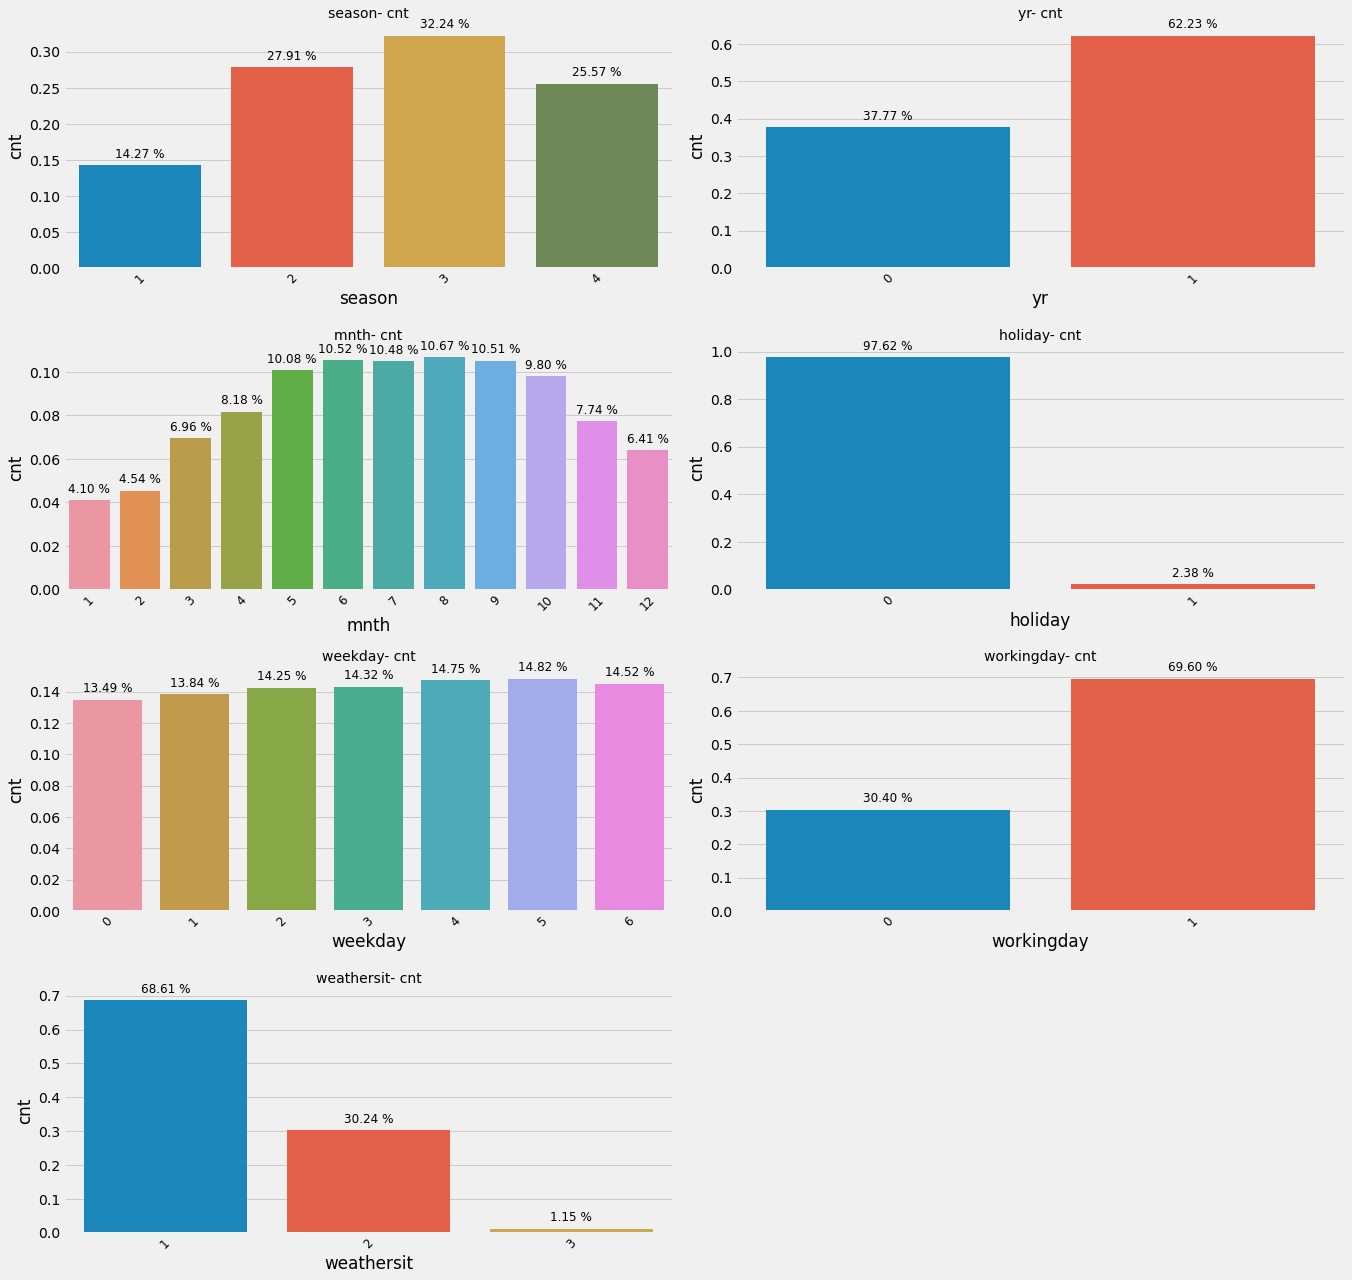

HIGH INFORMATION CONTENT TABLE


,Predictor,Max_val,Min_val,Variance
3,holiday,0.976166,0.023834,0.952331
6,weathersit,0.686131,0.011507,0.674624
5,workingday,0.696045,0.303955,0.392090
1,yr,0.622254,0.377746,0.244508
0,season,0.322449,0.142673,0.179776
2,mnth,0.106718,0.041003,0.065716
4,weekday,0.148226,0.134928,0.013298


In [211]:
uv(cat_var_lst, 1, 19, 18)
print("HIGH INFORMATION CONTENT TABLE")
info_cnt_df.sort_values(by="Variance", ascending=False)

Now the variation of data shown in the boxplots are much clearly represented graphically and numerically. The variations are more or less similar except the case of “workingday” and “holiday” columns. The reason is below.<br>
For month, day, season etc., the occurrence are uniform so when we find the group wise sum of ‘cnt’ column in percentage we can neglect to find per unit entity as that will not affect much. But in order to compare sum of ‘cnt’ column between holiday (group-wise) and non-holiday we need to compare per day wise to understand the actual variance, so is for workingday. So in below plot we normalize the scale to compare per day wise and got the result which more reliable.


Variation of Group-wise Sum of 'cnt'in Percentage Per Unit Day


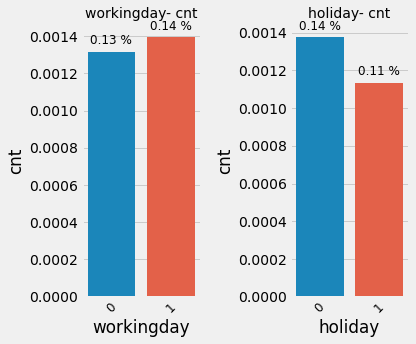

In [212]:
print("Variation of Group-wise Sum of 'cnt'in Percentage Per Unit Day")
uv(['workingday',"holiday"], 0, 6,5)

According to bar plot, The actual variance is less for each case compariong to other entries in our High Information Content table. So those are not important variables for us.

#### So mathematically it is found that our most important categorical variables are 
 -weathersit<br>
 -yr<br>
 -season<br>
#### and we put our numerical most important variable "temp" (importance found from correlation matrix above) top of them. 

## <font color="blue">DATA Preparation:
- Converting some numeric values to categorical data</font>


In [213]:
# maping seasons
df.season = df.season.map({1: 'Spring',2:'Summer',3:'Fall',4:'Winter'})

In [214]:
# maping month
df['mnth'] = df['mnth'].apply(lambda x: calendar.month_abbr[x])

In [215]:
# weathersit is mapped based on the info given.
df.weathersit = df.weathersit.map({1:'Clear',2:'Mist_Cloudy', 3:'Light_Snow_Rain',4:'Heavy_Snow_Rain'})

In [216]:
# 1-1-2018 was monday and that day, here is tagged as 6. So all numbers are mapped in that manner.
df.weekday = df.weekday.map({5:"Sunday",6:"Monday",0:"Tuesday",1:"Wednesday",2:"Thrusday",3:"Friday",4:"Saturday"})

* creating dummy variables

In [217]:
binary_cat_var=["yr","holiday","workingday"]
other_cat_var=['season', 'mnth', 'weekday', 'weathersit']

In [218]:
#Creating dummy variables and dropping the first column
dum_var=pd.get_dummies(df[other_cat_var], drop_first=True)
#dum_var

In [219]:
df=pd.concat([dum_var, df], axis=1)
df.drop(['season','mnth','weekday','weathersit'], axis =1, inplace=True)

In [220]:
df.columns

Index(['season_Spring', 'season_Summer', 'season_Winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thrusday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Light_Snow_Rain',
       'weathersit_Mist_Cloudy', 'yr', 'holiday', 'workingday', 'temp', 'hum',
       'windspeed', 'cnt'],
      dtype='object')

In [221]:
#Now, to keep same format for all categorical variables (those are treated as dummy or binary variables) the following variables type are changed.
df.yr=df.yr.astype("uint8")
df.workingday=df.workingday.astype("uint8")
df.holiday=df.holiday.astype("uint8")

In [222]:
#qck()

## <font color="blue">Splitting the Data into Training and Testing Sets</font>

In [223]:
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)
print(df_train.shape, df_test.shape)

(510, 29) (219, 29)


## <font color="blue">Rescaling the Features </font>

In [224]:
scaler = MinMaxScaler()
num_vars = ['cnt','hum','windspeed','temp']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

<ipython-input-224-41c3647d0c13>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [225]:
print(df_train.columns)
df_train.head()

Index(['season_Spring', 'season_Summer', 'season_Winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thrusday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Light_Snow_Rain',
       'weathersit_Mist_Cloudy', 'yr', 'holiday', 'workingday', 'temp', 'hum',
       'windspeed', 'cnt'],
      dtype='object')


,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,weekday_Wednesday,weathersit_Light_Snow_Rain,weathersit_Mist_Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0.509887,0.575354,0.300794,0.864243
576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0.815169,0.725633,0.264686,0.827658
426,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0.442393,0.640189,0.255342,0.465255
728,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.245101,0.498067,0.663106,0.204096
482,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0.395666,0.504508,0.188475,0.482973


### 1st Var
#### Started with 'temp'. A list is declared above the user defined function.

In [226]:
y_train = df_train['cnt']
X_train = df_train[mdl_list]
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
print(lr.summary())
#print(vif_runner(X_train))
print("Available Features: " , df_train.columns)
print("Used Features: " , X_train.columns.tolist)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     359.1
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           5.80e-61
Time:                        22:57:20   Log-Likelihood:                 174.84
No. Observations:                 510   AIC:                            -345.7
Df Residuals:                     508   BIC:                            -337.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1698      0.020      8.628      0.0

### 2nd Var - "yr"

In [227]:
append_feature("yr")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     564.9
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          9.25e-130
Time:                        22:57:20   Log-Likelihood:                 337.38
No. Observations:                 510   AIC:                            -668.8
Df Residuals:                     507   BIC:                            -656.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0796      0.015      5.331      0.0

### 3rd Var - "weathersit_Light_Snow_Rain"

In [228]:
append_feature("weathersit_Light_Snow_Rain") #This gives beetter result than its complement set
#remove_feature('weathersit_Mist_Cloudy')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     434.7
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.39e-139
Time:                        22:57:20   Log-Likelihood:                 363.51
No. Observations:                 510   AIC:                            -719.0
Df Residuals:                     506   BIC:                            -702.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 4th Var -season_Spring

In [229]:
append_feature("season_Spring") #This gives beetter result than its parrallel sets
#remove_feature('season_Summer')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     435.3
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          4.36e-162
Time:                        22:57:20   Log-Likelihood:                 419.07
No. Observations:                 510   AIC:                            -828.1
Df Residuals:                     505   BIC:                            -807.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 5th var

In [230]:
append_feature('mnth_Sep')
#remove_feature('mnth_Jan')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     359.2
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.48e-163
Time:                        22:57:20   Log-Likelihood:                 425.64
No. Observations:                 510   AIC:                            -839.3
Df Residuals:                     504   BIC:                            -813.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 6th Var

In [231]:
append_feature('mnth_Jul')
#remove_feature('mnth_Jan')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     305.4
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          4.05e-164
Time:                        22:57:20   Log-Likelihood:                 430.00
No. Observations:                 510   AIC:                            -846.0
Df Residuals:                     503   BIC:                            -816.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 7th Var

In [232]:
append_feature('weathersit_Mist_Cloudy')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     308.5
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          2.77e-177
Time:                        22:57:20   Log-Likelihood:                 463.83
No. Observations:                 510   AIC:                            -911.7
Df Residuals:                     502   BIC:                            -877.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 8th Var

In [233]:
mdl_list.append("season_Winter")
#mdl_list.remove("windspeed")
y_train = df_train['cnt']
X_train = df_train[mdl_list]
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
type(lr)
print(lr.summary())
print(vif_runner(X_train))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     280.6
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.21e-179
Time:                        22:57:20   Log-Likelihood:                 472.34
No. Observations:                 510   AIC:                            -926.7
Df Residuals:                     501   BIC:                            -888.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# <font color="blue">Residual Analysis</font>

In [234]:
y_train_predict = lr.predict(X_train_sm)

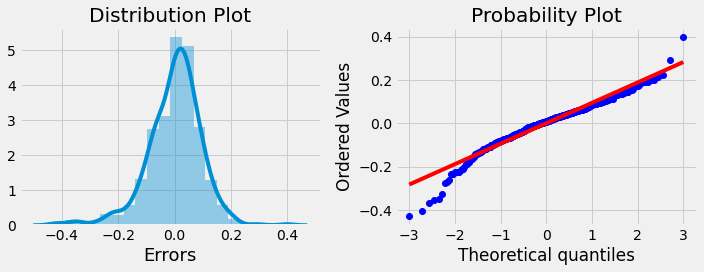

In [235]:
# Plot the histogram of the error terms
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
ax1=sns.distplot((y_train - y_train_predict), bins = 20)
ax1.set_title("Distribution Plot") 
plt.xlabel('Errors', fontsize = 18)                       
plt.subplot(1,2,2)
ax2=stats.probplot(y_train-y_train_predict, plot=plt)
         
plt.tight_layout()
plt.show()


## <font color="blue"> Making Predictions Using the Final Model<font>

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. third model.

#### Applying the scaling on the test sets

In [236]:
num_vars = ['cnt','hum','windspeed','temp']
df_test[num_vars] = scaler.transform(df_test[num_vars])

<ipython-input-236-e664c940933b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[num_vars] = scaler.transform(df_test[num_vars])
C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Dividing into X_test and y_test

In [237]:
y_test = df_test["cnt"]
X_test = df_test[mdl_list]

In [238]:
# Adding constant variable to test dataframe
X_test_sm = sm.add_constant(X_test)

In [239]:
# Making predictions 
#y_train_predict = lr.predict(X_train_sm)
y_test_predict = lr.predict(X_test_sm)

In [240]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_predict)

0.809103523693091

In [241]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_test_predict)
mse

0.00906678241523806

## <font color="blue"> Model Evaluation</font>

Let's now plot the graph for actual versus predicted values.

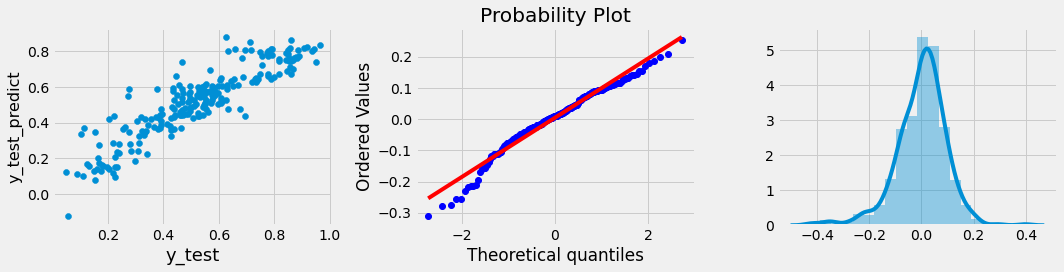

In [254]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure(figsize=(15,4))
ax1=plt.subplot(1,3,1)
ax1=plt.scatter(y_test, y_test_predict)
#fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_test_predict', fontsize = 16)
plt.subplot(1,3,2)
ax2=stats.probplot(y_test-y_test_predict, plot=plt)
plt.subplot(1,3,3)
ax3=sns.distplot((y_train - y_train_predict), bins = 20)
plt.tight_layout()
plt.show()

In [243]:
param = pd.DataFrame(lr.params)
param.insert(0,'Variables',param.index)
param.rename(columns = {0:'Coefficient value'},inplace = True)
param.sort_values(by = 'Coefficient value',ascending = False,inplace = True)
param

,Variables,Coefficient value
temp,temp,0.472070
yr,yr,0.233432
const,const,0.191478
mnth_Sep,mnth_Sep,0.062086
season_Winter,season_Winter,0.052934
mnth_Jul,mnth_Jul,-0.067776
weathersit_Mist_Cloudy,weathersit_Mist_Cloudy,-0.077803
season_Spring,season_Spring,-0.113573
weathersit_Light_Snow_Rain,weathersit_Light_Snow_Rain,-0.296126


Hence the equation of best fitted line is:

 cnt = 0.191478 + 0.472070  X  temp + 0.233482  X  yr + 0.062086 X mnth_Sep + 0.052934 X season_Winter	 -0.067776 X mnth_Jul -0.077803 X weathersit_Mist_Cloudy  -0.113573 X season_Spring -0.296126 X weathersit_Light_Snow_Rain

##### All the positive coefficients like temp,season_Summer imply that an increment in their value(s) cause the increment of cnt.

##### All the positive coefficients like temp,season_Summer imply that an increment in their value(s) cause the decrement of cnt.

# Remark & Conclusion:

- Temp is the most important features the largest coefficient.
- The other important features is weathersit_Light Snow & Rain.
- Bike rentals is more lucrative in september


***This indicates that the bike rentals is majorly affected by temperature,season and month.***

***The analysis is validated with all standard assumptions taken for linear regression.***